1. create conda env and activate
2. install 3.8.11 in conda env
3. install pip
4. install reqs

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torchvision.io import read_image
import ai8x
from distiller import apputils
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import datasets.memes as memes
import numpy as np
from models import memenet

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'models'))

%matplotlib inline

### Test set evaluation of the quantized model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Configuring device: MAX78000, simulate=True.


Text(0.5, 1.0, 'soll:rsz_fry.png, ist:rsz_fry.png')

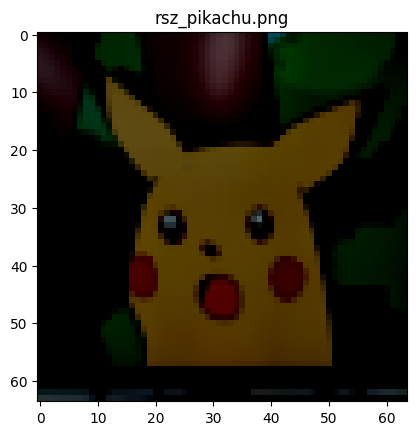

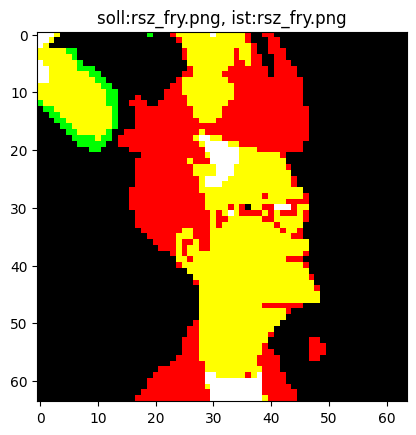

In [80]:
#check generated sample npy file
labels = ["rsz_this_fine.png", "rsz_fry.png", "rsz_grumpy_cat.png", "rsz_pikachu.png"]

sample_input = np.load('../ai8x-synthesis/tests/sample_memes.npy')
num_classes = 4

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

args = Args(act_mode_8bit=True) #IMPORTANT: if this is not set to true, the test set will be float instead of int, and so you can't use the quantized model
data_path = os.path.join(os.path.dirname('./'), 'data')

_,ds_test = memes.memes_get_datasets((data_path, args), load_train=False, load_test=True)

ai8x.set_device(85, True, True)
model = memenet.MemeNet(num_classes=num_classes, num_channels=3, dimensions=(64,64))

def predict_label(img):
    model.eval()
    with torch.no_grad():
        out = model(img)
        predicted = torch.argmax(out, dim=1)
        return predicted

checkpoint_path = '../ai8x-synthesis/trained/qat_best-q.pth.tar'

model = apputils.load_lean_checkpoint(model, checkpoint_path)
ai8x.update_model(model)

plt.figure()
plt.imshow(sample_input.transpose(1,2,0))

#predict 10th sample
model_sample_input = torch.from_numpy(sample_input).unsqueeze(0).float()
predicted = predict_label(model_sample_input)
plt.title(labels[predicted])

idx = 10
test_input, test_label = ds_test[idx]
predicted = predict_label(test_input.unsqueeze(0))
plt.figure()
plt.imshow(test_input.permute(1,2,0))
plt.title("soll:%s, ist:%s" % (labels[test_label], labels[predicted]))


In [81]:
test_set_len = len(ds_test)
misclassified_cnt = 0
classification_cnt = 0

for i in range(test_set_len):
    img, label = ds_test[i]
    img_model = img.unsqueeze(0)
    pred = model(img_model)
    pred_label = pred.argmax(dim=1).squeeze().item()
    print('%s. Predicted: %s, true: %s' % (i, pred_label, label))
    if pred_label != label:
        misclassified_cnt += 1
    else:
        classification_cnt += 1

print('Misclassified: %d, Classified: %d' % (misclassified_cnt, classification_cnt))

0. Predicted: 0, true: 0
1. Predicted: 2, true: 2
2. Predicted: 3, true: 3
3. Predicted: 1, true: 3
4. Predicted: 2, true: 2
5. Predicted: 1, true: 1
6. Predicted: 1, true: 1
7. Predicted: 2, true: 2
8. Predicted: 0, true: 0
9. Predicted: 1, true: 1
10. Predicted: 1, true: 1
11. Predicted: 0, true: 0
12. Predicted: 2, true: 2
13. Predicted: 1, true: 1
14. Predicted: 0, true: 0
15. Predicted: 3, true: 3
16. Predicted: 3, true: 3
17. Predicted: 0, true: 0
18. Predicted: 3, true: 3
19. Predicted: 3, true: 3
20. Predicted: 0, true: 0
21. Predicted: 3, true: 3
22. Predicted: 2, true: 2
23. Predicted: 2, true: 2
24. Predicted: 3, true: 3
25. Predicted: 1, true: 1
26. Predicted: 0, true: 0
27. Predicted: 0, true: 0
28. Predicted: 0, true: 0
29. Predicted: 1, true: 1
30. Predicted: 1, true: 1
31. Predicted: 2, true: 2
32. Predicted: 1, true: 1
33. Predicted: 2, true: 2
34. Predicted: 0, true: 0
Misclassified: 1, Classified: 34
